In [1]:
import numpy as np
import salabim as sim
import sqlite3 as sql
import pandas as pd
import random
import arrow
from time import time
pd.set_option('display.max_columns', None)

In [2]:
def Normal(a, b):
    return sim.Bounded(sim.Normal(a, b), lowerbound=0).sample()

def Uniform(a, b):
    return sim.Uniform(a, b).sample()

class Chair():
    def __init__(self):
        self.occupied = False
        self.start = []
        self.end = []
        
class Staff():
    def __init__(self):
        self.busy = False
        self.start = []
        self.end = []

class BloodDonor():
    def __init__(self):
        self.arrival = env.now()
        self.show = Uniform(0,1) < 0.6901
        self.rejected = Uniform(0,1) < 0.0147
        self.failed =  Uniform(0,1) < 0.0545
        self.declaration = Normal(5,5/4)
        self.reception = Normal(3,3/4)
        self.preperation = Normal(2,2/4)
        self.collection = Normal(8.125230202578269, 4.17646751840282) if not self.failed else Normal(8.576923076923077, 2.7057357441479324)
        self.check = Normal(1,1/4)
        self.rest = Normal(10,10/4)
        self.clean = Normal(1,1/4)
        self.type = rejected_blood_donors if self.rejected else failed_blood_donors if self.failed else blood_donors
        self.chair_type = blood_chairs
        
        self.wait = {}
        self.timestamps = {}
        
        self.arrival_arrow = None
        self.leaving_arrow = None
        
        blood_donors_list.append(self)
        
class PlasmaDonor():
    def __init__(self):
        self.arrival = env.now()
        self.show = Uniform(0,1) < 0.7152
        self.rejected = Uniform(0,1) < 0.0048
        self.failed = Uniform(0,1) < 0.0281
        self.declaration = Normal(5,5/4)
        self.reception = Normal(3,3/4)
        self.preperation = Normal(2,2/4)
        self.collection = Normal(33.95558775892933, 12.96371026189495) if not self.failed else Normal(9.38888888888889, 7.003746792667655)
        self.check = Normal(1,1/4)
        self.rest = Normal(1,1/4)
        self.clean = Normal(4,4/4)
        self.type = rejected_plasma_donors if self.rejected else failed_plasma_donors if self.failed else plasma_donors
        self.chair_type = plasma_chairs
        
        self.wait = {}
        self.timestamps = {}
        
        self.arrival_arrow = None
        self.leaving_arrow = None
        
        plasma_donors_list.append(self)

class DonorProcess(sim.Component):
    def __init__(self, donor, chairs, staff, rows_list):
            super(DonorProcess, self).__init__()
            self.donor = donor
            self.chairs = chairs
            self.staff = staff
            self.rows_list = rows_list
    
    def process(self):

        donor = self.donor
        chairs = self.chairs
        rows_list = self.rows_list
        
        if donor.show:
            
            before = env.now()
            
            now = arrow.now().replace(hour=8, minute=0, second=0, microsecond=0)
            arrival = now.shift(minutes=+donor.arrival)
            donor.timestamps['arrival'] = arrival.format('HH:mm:ss')
            
            before_declaration = env.now()
            yield self.request(donor.type, declarations)
            donor.wait['declaration'] = env.now() - before_declaration
            yield self.hold(donor.declaration)
            self.release(declarations)

            before_reception = env.now()
            yield self.request(receptions, staff)
            for s in self.staff:
                if not s.busy:
                    break;
            s.busy = True
            s.start += [env.now()]
            donor.wait['reception'] = env.now() - before_reception
            yield self.hold(donor.reception)
            self.release(receptions, staff)
            s.busy = False
            s.end += [env.now()]

            if donor.rejected:

                self.release(donor.type)

            else:

                before_preperation = env.now()
                yield self.request(staff, donor.chair_type)
                for s in self.staff:
                    if not s.busy:
                        break;
                s.busy = True
                s.start += [env.now()]
                donor.wait['preperation'] = env.now() - before_preperation
                for chair in chairs:
                    if not chair.occupied:
                        break
                chair.occupied = True
                chair.start += [env.now()]
                yield self.hold(donor.preperation)
                self.release(staff)
                s.busy = False
                s.end += [env.now()]

                yield self.hold(donor.collection)

                before_check = env.now()
                yield self.request(staff)
                for s in self.staff:
                    if not s.busy:
                        break;
                s.busy = True
                s.start += [env.now()]
                donor.wait['check'] = env.now() - before_check
                yield self.hold(donor.check)
                self.release(staff)
                s.busy = False
                s.end += [env.now()]

                yield self.hold(donor.rest)
                self.release(donor.type)

                before_clean = env.now()
                yield self.request(staff)
                for s in self.staff:
                    if not s.busy:
                        break;
                s.busy = True
                s.start += [env.now()]
                donor.wait['clean'] = env.now() - before_clean
                yield self.hold(donor.clean)
                self.release(staff, donor.chair_type)
                chair.occupied = False
                chair.end += [env.now()]
                s.busy = False
                s.end += [env.now()]
                
            done = env.now() - before
            
            leaving = now.shift(minutes=+donor.arrival + done)
            donor.timestamps['leaving'] = leaving.format('HH:mm:ss')
            donor.timestamps['duration'] = "{} min".format(round((leaving - arrival).seconds / 60, 2))
            
            donor.arrival_arrow = arrival
            donor.leaving_arrow = leaving
            
            rows_list += [{'show': vars(donor)['show'], 'rejected': vars(donor)['rejected'], 'failed': vars(donor)['failed'], **vars(donor)['wait'], **vars(donor)['timestamps']}]

        
class BloodDonorGenerator(sim.Component):
    def process(self):
        #while True:
        for _ in range(50):
            yield self.hold(sim.Bounded(sim.Normal(19.4534373476353, 14.403435300230546), lowerbound=0, upperbound=10).sample())
            donor = BloodDonor()
            DonorProcess(donor, blood_donor_chairs, current_staff, blood_rows_list)

class PlasmaDonorGenerator(sim.Component):
    def process(self):
        #while True:
        for _ in range(50):
            yield self.hold(sim.Bounded(sim.Normal(12.490108879006288, 11.78013587746875), lowerbound=0, upperbound=10).sample())
            donor = PlasmaDonor()
            DonorProcess(donor, plasma_donor_chairs, current_staff, plasma_rows_list)

print('-----------------------------------')
print()

for i in range(1):
        
    env = sim.Environment(time_unit='minutes', trace=False, random_seed='*')
    
    blood_donors_list = []
    plasma_donors_list = []
    
    blood_rows_list = []
    plasma_rows_list = []
    
    blood_donor_chairs = [Chair() for _ in range(4)]
    plasma_donor_chairs = [Chair() for _ in range(7)]
    current_staff = [Staff() for _ in range(4)]

    BloodDonorGenerator()
    PlasmaDonorGenerator()

    blood_donors = sim.Resource("blood_donors", float('inf'))
    plasma_donors = sim.Resource("plasma_donors", float('inf'))
    rejected_blood_donors = sim.Resource("rejected_blood_donors", float('inf'))
    rejected_plasma_donors = sim.Resource("rejected_plasma_donors", float('inf'))
    failed_blood_donors = sim.Resource("failed_blood_donors", float('inf'))
    failed_plasma_donors = sim.Resource("failed_plasma_donors", float('inf'))
    declarations = sim.Resource("declarations", 2)
    receptions = sim.Resource("receptions", 2)
    blood_chairs = sim.Resource("blood_chairs", 4)
    plasma_chairs = sim.Resource("plasma_chairs", 7)
    staff = sim.Resource("staff", 4)

    env.run()
    
    blood_dataframe = pd.DataFrame(blood_rows_list)
    plasma_dataframe = pd.DataFrame(plasma_rows_list)

    print('Blood')
    print('Complete\t', blood_donors.claimers().length_of_stay.mean())
    print('Rejected\t', rejected_blood_donors.claimers().length_of_stay.mean())
    print('Failed\t\t', failed_blood_donors.claimers().length_of_stay.mean())
    print()
    print('Plasma')
    print('Complete\t', plasma_donors.claimers().length_of_stay.mean())
    print('Rejected\t', rejected_plasma_donors.claimers().length_of_stay.mean())
    print('Failed\t\t', failed_plasma_donors.claimers().length_of_stay.mean())

    print()
    print('-----------------------------------')
    print()

-----------------------------------

Blood
Complete	 29.98709525545815
Rejected	 nan
Failed		 28.423845525635834

Plasma
Complete	 54.83672162352171
Rejected	 nan
Failed		 nan

-----------------------------------



In [3]:
from matplotlib import rc, rcParams
rc('text', usetex=True)
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Rectangle
import matplotlib.dates as md
import seaborn as sns
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [4]:
import itertools

def plot_occupancy(chairs_collections, label, colors=['#ea5455', '#ff9a3c'], bar_height=10, rounded_corners=True):
    space = bar_height * 1.2
    fig,ax = plt.subplots(tight_layout=True)
    currentAxis = fig.gca()
    start, end = [], []
    for chairs_index, chairs in enumerate(chairs_collections):
        for index, chair in enumerate(chairs):
            if index % 2 == 0:
                currentAxis.add_patch(Rectangle((-200, (index + len(chairs_collections[chairs_index - 1]) * chairs_index) * space - bar_height * 0.1), 3000, bar_height * 1.2, facecolor='#000000', edgecolor='none', alpha=0.04))
            for i in range(len(chair.start)):
                if rounded_corners:
                    currentAxis.add_patch(FancyBboxPatch((chair.start[i] + (bar_height / 4), (index + len(chairs_collections[chairs_index - 1]) * chairs_index) * space + (bar_height / 4)), chair.end[i] - chair.start[i] - (bar_height / 2), (bar_height / 2), facecolor=colors[chairs_index], edgecolor='none', boxstyle=mpatches.BoxStyle("Round", pad=(bar_height / 4), rounding_size=(bar_height / 6))))
                    currentAxis.add_patch(FancyBboxPatch((chair.start[i] + (bar_height / 4), (index + len(chairs_collections[chairs_index - 1]) * chairs_index) * space + (bar_height / 4)), chair.end[i] - chair.start[i] - (bar_height / 2), (bar_height / 2), facecolor='none', edgecolor='black', alpha=0.4, boxstyle=mpatches.BoxStyle("Round", pad=(bar_height / 4) - (bar_height / 60), rounding_size=(bar_height / 6) - (bar_height / 55))))
                else:
                    currentAxis.add_patch(Rectangle((chair.start[i], index * space), chair.end[i] - chair.start[i], bar_height, facecolor=colors[chairs_index], edgecolor='none'))
                start += [chair.start[i]]
                end += [chair.end[i]]
    number_of_chairs = len(list(itertools.chain(*chairs_collections)))
    currentAxis.set_ylim([-bar_height * 0.2, number_of_chairs * space])
    currentAxis.set_xlim([0, max(end)])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.yticks([(bar_height / 2) + space * i for i in range(number_of_chairs)], [r'\textbf{' + r'{} {}'.format(label, i + 1) + r'}' for i in range(number_of_chairs)], fontsize=14)
    now = arrow.now().replace(hour=8, minute=0, second=0, microsecond=0)
    plt.xticks([i for i in range(0, int(max(end)), 30)], [now.shift(minutes=30*(i//30)).format('HH:mm') for i in range(0, int(max(end)), 30)], fontsize=14)
    ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
    ax.set_aspect(1.0)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('schedule.pdf')
    plt.show()

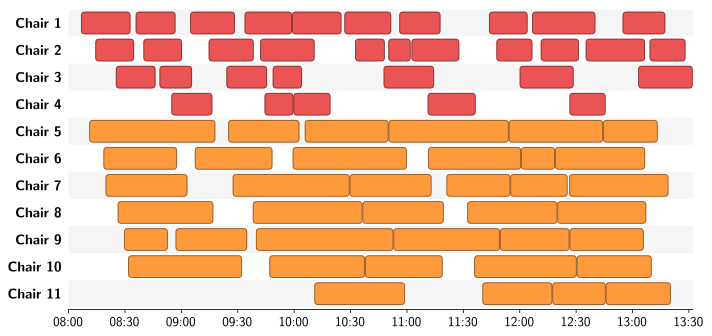

In [5]:
plt.rcParams["figure.figsize"] = (10,5)
plot_occupancy([blood_donor_chairs, plasma_donor_chairs], r"Chair", bar_height = 12)

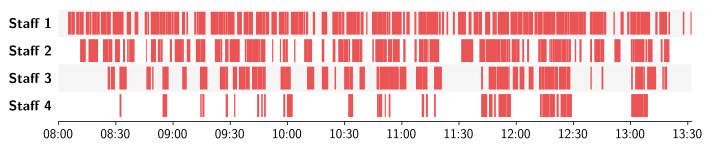

In [6]:
plot_occupancy([current_staff], r"Staff", bar_height=12, rounded_corners=False)

In [7]:
blood_dataframe.describe()

,declaration,reception,preperation,check,clean
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.520129,0.048127,0.250862,0.061503,0.069654
std,1.286735,0.145021,0.898582,0.185278,0.252499
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.675030,0.632454,4.446823,0.802615,1.170341


In [8]:
plasma_dataframe.describe()

,declaration,reception,preperation,check,clean
count,38.000000,38.000000,38.000000,38.000000,38.000000
mean,0.848290,0.044254,5.846160,0.083343,0.082744
std,1.794392,0.158985,7.625259,0.336092,0.336312
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.380005,0.000000,14.621777,0.000000,0.000000
max,7.058723,0.670959,21.561439,1.961139,1.984622


In [9]:
plasma_dataframe

,show,rejected,failed,declaration,reception,preperation,check,clean,arrival,leaving,duration
0,True,False,False,1.932655,0.000000,0.000000,0.000000,0.000000,08:20:08,08:52:47,32.65 min
1,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:10:59,08:57:40,46.68 min
2,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:13:06,09:03:12,50.08 min
3,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:19:27,09:16:59,57.53 min
4,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:04:56,09:18:02,73.1 min
5,True,False,False,0.449192,0.000000,0.000000,0.000000,0.562159,08:22:46,09:32:15,69.47 min
6,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:50:37,09:34:58,44.35 min
7,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:58:20,09:48:26,50.1 min
8,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,09:17:03,10:02:45,45.7 min
9,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,09:20:01,10:29:29,69.47 min


In [10]:
blood_dataframe

,show,rejected,failed,declaration,reception,preperation,check,clean,arrival,leaving,duration
0,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:00:00,08:32:55,32.92 min
1,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:05:35,08:34:48,29.22 min
2,True,False,False,0.993514,0.000000,0.000000,0.000000,0.000000,08:14:38,08:46:14,31.6 min
3,True,False,True,0.000000,0.000000,0.000000,0.000000,0.000000,08:27:42,08:56:53,29.18 min
4,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:33:05,09:00:20,27.23 min
5,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:40:25,09:05:39,25.23 min
6,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:46:27,09:16:27,30.0 min
7,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,08:55:54,09:28:29,32.57 min
8,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,09:07:31,09:38:28,30.93 min
9,True,False,False,0.000000,0.000000,0.000000,0.000000,0.031893,09:15:54,09:45:34,29.67 min
